# SedGen: examples

## Imports

In [1]:
import numpy as np
import numba as nb
from numba.typed import List
import numexpr as ne
import pandas as pd
import itertools
from operator import itemgetter
import gc
import copy

from scipy.stats import norm, lognorm, truncnorm
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter, deque
from sys import getsizeof

In [2]:
from sedgen.initialization import SedGen
from sedgen import initialization as ini
from sedgen import general as gen
from sedgen import preprocessing
from sedgen import geostatistics

In [3]:
%load_ext line_profiler
%load_ext memory_profiler

In [4]:
# Load jupyter extension to reload packages before executing user code.
# https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
# Reload all packages (except those excluded by %aimport) every time 
# before executing the Python code typed.
%autoreload 2

## Model input
___

### Parent rock characteristics

In [5]:
# Unit is mm³
parent_rock_volume = 1e9

# Mineral classes present in parent rock
minerals = ["Q", "P", "K", "B", "O", "A"]

### Modal mineralogy
This property will be represented by a mean value of parent rock samples.  
The mean value should be calculated based on clr transformed data, though.

In [6]:
# Modal mineralogy mean values f CA-NS of Heins(1992)
modal_mineralogy = np.array([0.30591989, 0.38159713, 0.26209888, 0.01882560, 0.00799247, 0.02356603])

### Interfacial composition
This property will be represented by a mean value of parent rock samples.  
The mean value should be calculated based on clr transformed data, though.

In [7]:
interface_proportions_true = None

### Crystal size distributions
This property will be based on a mean crystal size and standard deviation  
which will be represented as a log-normal distribution.

In [8]:
csds_CA_NS_means = np.array([0.309, 0.330, 0.244, 0.223, 0.120, 0.122])
csds_CA_NS_stds = np.array([0.823, 0.683, 0.817, 0.819, 0.554, 0.782])

In [9]:
crystal_strengths_normalized = gen.normalize(np.array([5, 2, 0.8, 2.5, 4, 3])).reshape(-1, 1)
crystal_strengths_normalized.sum()

0.9999999999999999

In [10]:
(crystal_strengths_normalized * crystal_strengths_normalized.T)

array([[0.08353102, 0.03341241, 0.01336496, 0.04176551, 0.06682482,
        0.05011861],
       [0.03341241, 0.01336496, 0.00534599, 0.0167062 , 0.02672993,
        0.02004745],
       [0.01336496, 0.00534599, 0.00213839, 0.00668248, 0.01069197,
        0.00801898],
       [0.04176551, 0.0167062 , 0.00668248, 0.02088276, 0.03341241,
        0.02505931],
       [0.06682482, 0.02672993, 0.01069197, 0.03341241, 0.05345985,
        0.04009489],
       [0.05011861, 0.02004745, 0.00801898, 0.02505931, 0.04009489,
        0.03007117]])

## Initialization

In [ ]:
%%time
sedgen_CA_NS = SedGen(minerals, 
                      parent_rock_volume, 
                      modal_mineralogy,
                      csds_CA_NS_means, 
                      csds_CA_NS_stds, 
                      learning_rate=10000, 
                      timed=True,
                      chem_weath_rates=[0.01, 0.05, 0.1, 0.03, 0.02, 0.04])

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 1.6196 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 3.9030 seconds
Counting interfaces...  Done in 0.0336 seconds
Correcting interface arrays for consistency...
too much Q 1
all good P 0
all good K 0
all good B 0
all good O 0
too few A -1
Initializing crystal size array... |Q|P|K|B|O|A| Done in 0.6292 seconds
Initializing inter-crystal breakage probability arrays...


In [19]:
%%time
sedgen_CA_NS = SedGen(minerals, 
                      parent_rock_volume, 
                      modal_mineralogy,
                      csds_CA_NS_means, 
                      csds_CA_NS_stds, 
                      learning_rate=10000, 
                      timed=True,
                      chem_weath_rates=[0.01, 0.05, 0.1, 0.03, 0.02, 0.04])

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Initializing bins...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 2.1820 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 3.4439 seconds
Counting interfaces...  Done in 0.0371 seconds
Correcting interface arrays for consistency...
too much Q 1
all good P 0
all good K 0
all good B 0
all good O 0
too few A -1
Initializing crystal size array... |Q|P|K|B|O|A| Done in 0.2199 seconds
Initializing inter-crystal breakage probability arrays...
Initializing model evolution arrays...
Initializing discretization for model's weathering...
100/100
---SedGen model initialization finished succesfully---
Wall time: 35.3 s


In [36]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

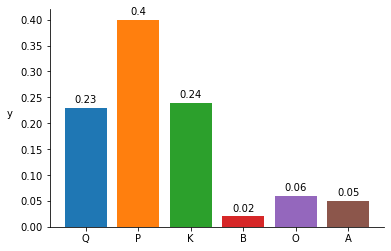

In [45]:
fig, ax = plt.subplots()
minerals_N_normalized = gen.normalize(sedgen_CA_NS.minerals_N)
rects = ax.bar(x=sedgen_CA_NS.minerals, height=np.round(minerals_N_normalized, 2), color=sns.color_palette())
autolabel(rects) 
plt.ylabel("y", rotation=0, labelpad=10)

sns.despine()
plt.savefig("_FIGURES/barplot_minerals_N_relative_CA-NS.pdf")
plt.show();

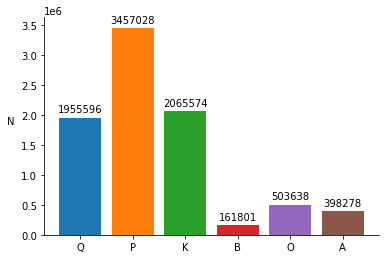

In [41]:
fig, ax = plt.subplots()
rects = ax.bar(x=sedgen_CA_NS.minerals, height=sedgen_CA_NS.minerals_N, color=sns.color_palette())
autolabel(rects) 
plt.ylabel("N", rotation=0, labelpad=10)

sns.despine()
plt.savefig("_FIGURES/barplot_minerals_N_CA-NS.pdf")
plt.show();

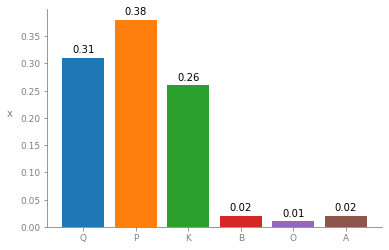

In [85]:
fig, ax = plt.subplots()
rects = ax.bar(x=sedgen_CA_NS.minerals, height=np.round(sedgen_CA_NS.modal_mineralogy, 2), color=sns.color_palette())
autolabel(rects) 

# Set the color of the visible spines
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')

# Set general tick parameters
ax.tick_params(axis='both',
               direction='out',
               colors='grey',
               labelsize=9)

ax.set_ylabel("x", rotation=0, labelpad=10, color='grey')

# Set facecolor of figure
plt.gcf().set_facecolor('white')

sns.despine()
plt.savefig("_FIGURES/barplot_modal_mineralogy_CA-NS.pdf")
plt.show();

In [28]:
np.sum(sedgen_CA_NS.volume_bins_medians_matrix[sedgen_CA_NS.pcg_chem_weath_array_new, sedgen_CA_NS.pcgs_new, sedgen_CA_NS.crystal_size_array_new])

1000098378.8610446

In [29]:
np.sum(sedgen_CA_NS.simulated_volume)

1000010368.3232061

## Mechanical Weathering

In [20]:
%%time
sedgen_CA_NS_mech = \
    sedgen_CA_NS.weathering(
        operations=["intra_cb", "inter_cb"], 
        timesteps=100, inplace=False)

After 78 steps all pcgs have been broken down to mcg
Wall time: 1min 55s


In [145]:
%%time
sedgen_CA_NS_mech2 = sedgen_CA_NS.weathering(operations=["intra_cb", "inter_cb"], 
                                             timesteps=30, inplace=False)

Wall time: 38.3 s


In [52]:
n_pcgs = len(sedgen_CA_NS_mech.pcgs_new)
n_pcgs

71132

In [53]:
pcgs_volumes = np.zeros(n_pcgs)

for p in range(n_pcgs):
    pcgs_volumes[p] = np.sum(sedgen_CA_NS_mech.volume_bins_medians_matrix[sedgen_CA_NS_mech.pcg_chem_weath_array_new[p], sedgen_CA_NS_mech.pcgs_new[p], sedgen_CA_NS_mech.crystal_size_array_new[p]])

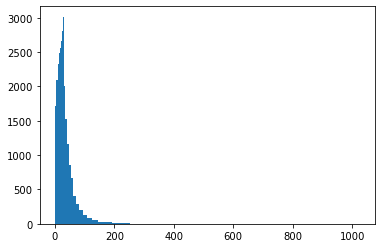

In [59]:
plt.hist(gen.calculate_equivalent_circular_diameter(pcgs_volumes), bins=[2**x for x in np.linspace(-10, 10, 100)])
plt.show();

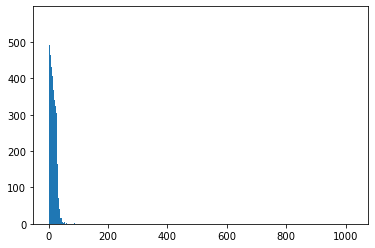

In [50]:
plt.hist(gen.calculate_equivalent_circular_diameter(pcgs_volumes), bins=[2**x for x in np.linspace(-10, 10, 2000)])
plt.show();

In [38]:
np.sort(gen.calculate_equivalent_circular_diameter(pcgs_volumes))[-5:]

array([404.09972532, 420.32726578, 462.98930974, 525.45629446,
       586.53330711])

In [30]:
sedgen_CA_NS_mech.vol_pcg_evolution[9]

1000086853.6562829

C:\Users\u0108248\AppData\Local\Continuum\miniconda3\envs\sedgen\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


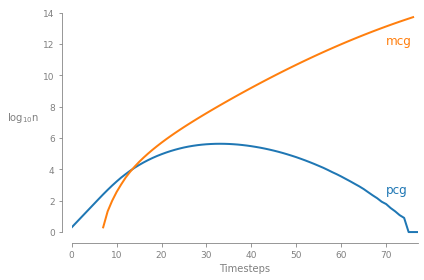

In [111]:
fig, ax = plt.subplots()

ax.plot(np.log10(sedgen_CA_NS_mech.pcg_additions), label="pcg", lw=2)
ax.plot(np.log10(sedgen_CA_NS_mech.mcg_additions), label="mcg", lw=2)

ax.text(70, 12, "mcg", color=sns.color_palette()[1], fontsize=12)
ax.text(70, 2.5, "pcg", color=sns.color_palette()[0], fontsize=12)

# Set the color of the visible spines
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')

ax.set_xlim(0, 77)

ax.spines['bottom'].set_bounds(0, 77)
ax.spines['left'].set_bounds(0, 14)

ax.spines['left'].set_position(('outward', 10))

# Set general tick parameters
ax.tick_params(axis='both',
               direction='out',
               colors='grey',
               labelsize=9)

ax.set_xlabel("Timesteps", color='grey')
ax.set_ylabel("$\log_{10}$n", rotation=0, labelpad=20, color='grey')

# Set facecolor of figure
plt.gcf().set_facecolor('white')

sns.despine()
# plt.legend()
plt.tight_layout()
plt.savefig("_FIGURES/lineplot_pcgmcg_evolution_mech_CA-NS.pdf")
plt.show();

C:\Users\u0108248\AppData\Local\Continuum\miniconda3\envs\sedgen\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
C:\Users\u0108248\AppData\Local\Continuum\miniconda3\envs\sedgen\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


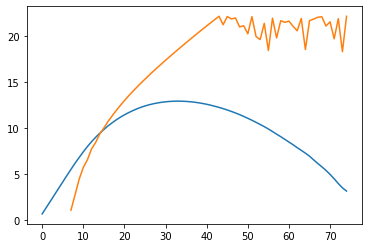

In [93]:
plt.plot(np.log(sedgen_CA_NS_mech.pcg_additions))
plt.plot(np.log(sedgen_CA_NS_mech.mcg_additions))
pass;

In [65]:
np.sum(sedgen_CA_NS_mech.mcg[0][0][:1000])

3311106970

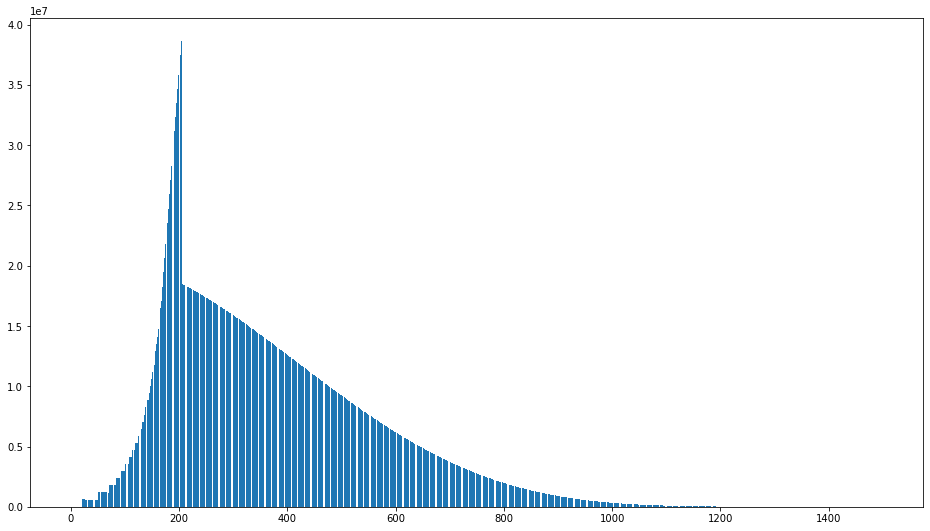

In [66]:
fig, ax = plt.subplots(figsize=(16,9))
plt.bar(range(0, 1500), height=sedgen_CA_NS_mech.mcg[0][0]);

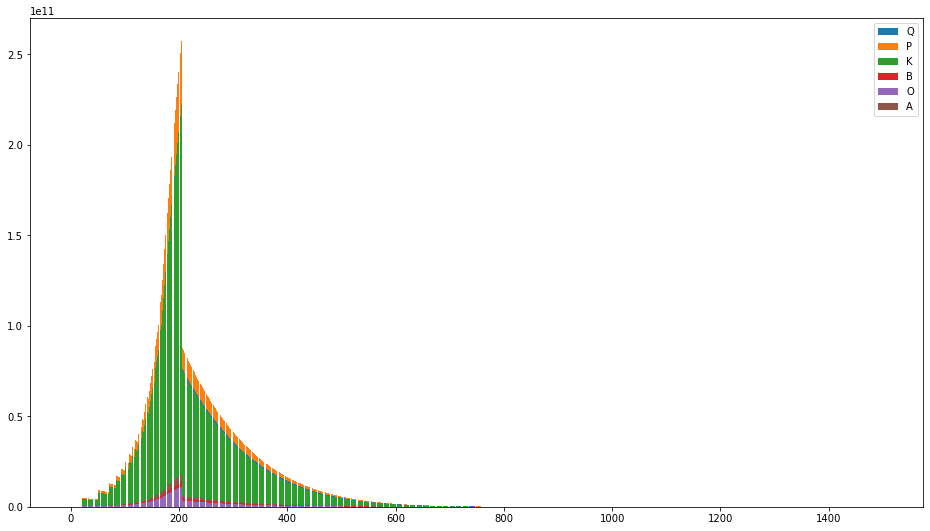

In [134]:
fig, ax = plt.subplots(figsize=(16,9))
for i, z in zip(range(6), [2, 1, 3, 5, 6, 4]):
    plt.bar(range(0, 1500), height=sedgen_CA_NS_mech.mcg[0][i], zorder=z, label=sedgen_CA_NS.minerals[i])
# plt.bar(range(0, 1500), height=sedgen_CA_NS_mech.mcg[0][3])
# plt.savefig("test.pdf")
plt.legend()
sns.despine()
plt.savefig("_FIGURES/barplot_csd_mcg_mech_CA-NS.pdf")
plt.show();

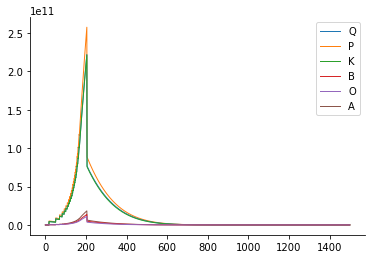

In [142]:
fig, ax = plt.subplots()
for i, z in zip(range(6), [2, 1, 3, 5, 6, 4]):
    plt.plot(range(0, 1500), sedgen_CA_NS_mech.mcg[0][i], zorder=z, label=sedgen_CA_NS.minerals[i], lw=1)
# plt.bar(range(0, 1500), height=sedgen_CA_NS_mech.mcg[0][3])
# plt.savefig("test.pdf")
plt.legend()
sns.despine()
plt.savefig("_FIGURES/lineplot_csd_mcg_mech_CA-NS.pdf")
plt.show();

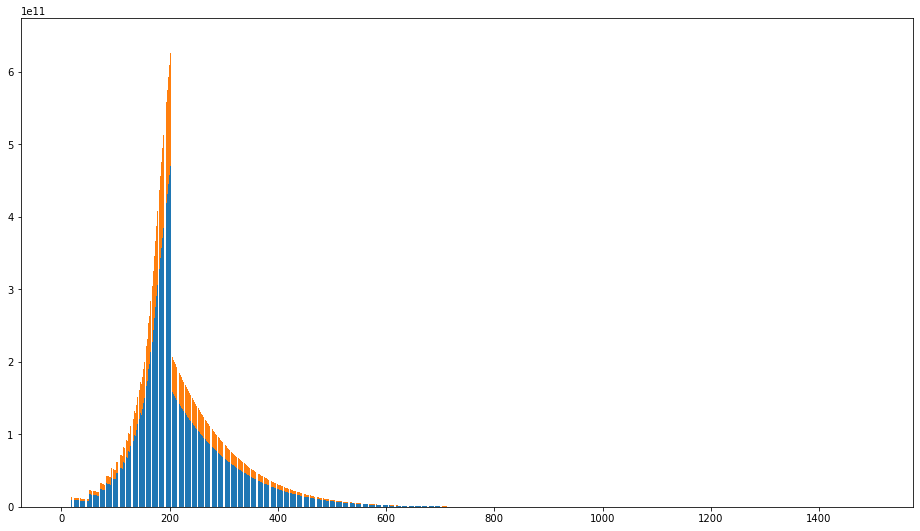

In [134]:
fig, ax = plt.subplots(figsize=(16,9))
plt.bar(range(0, 1500), height=sedgen_CA_NS_mech.mcg[0][0], zorder=10)
plt.bar(range(0, 1500), height=sedgen_CA_NS_mech.mcg[0][1])
# plt.savefig("test.pdf")
plt.show();

<BarContainer object of 1500 artists>

<BarContainer object of 1500 artists>

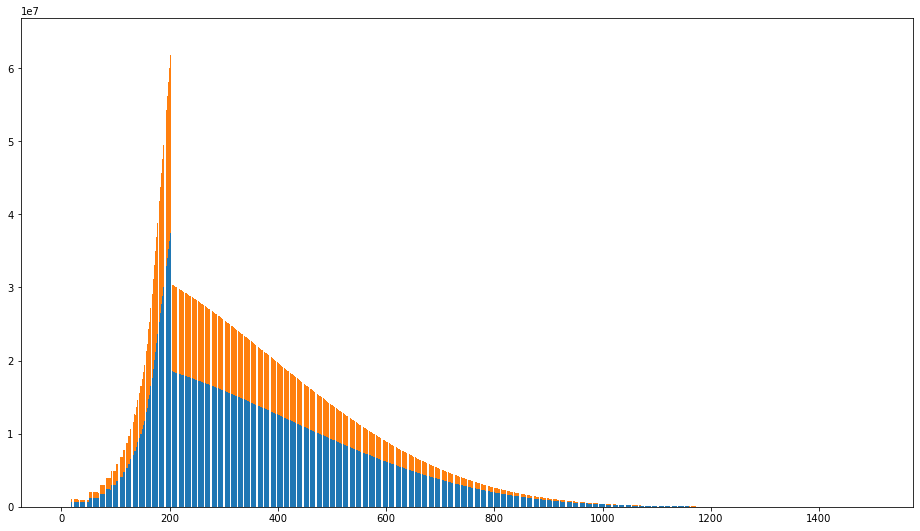

In [76]:
fig, ax = plt.subplots(figsize=(16,9))
plt.bar(range(0, 1500), height=sedgen_CA_NS_mech.mcg[0][0], zorder=10)
plt.bar(range(0, 1500), height=sedgen_CA_NS_mech.mcg[0][1])
plt.savefig("test.pdf")
plt.show();

In [116]:
2**-4

0.0625

In [120]:
sedgen_CA_NS_mech.size_bins[1100]

2.0

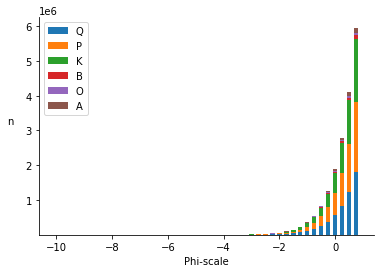

In [156]:
for d in range(0, 1100, 25):
    heights = np.sum(sedgen_CA_NS_mech2.mcg[0, :, d:d+100] * sedgen_CA_NS_mech2.volume_bins_medians_matrix[0, :, d:d+100], axis=1)
    for m in range(6):
        if d == 600:
            plt.bar(np.log2(sedgen_CA_NS_mech2.size_bins[d]), height=heights[m], width=0.15, bottom=np.sum(heights[:m]), label=minerals[m], color=sns.color_palette()[m])
        else:
            plt.bar(np.log2(sedgen_CA_NS_mech2.size_bins[d]), height=heights[m], width=0.15, bottom=np.sum(heights[:m]), color=sns.color_palette()[m])
plt.legend()
ax.set_xlabel([4, 3, 2, 1, 0, -1])
sns.despine()

plt.xlabel("Phi-scale")
plt.ylabel("n", rotation=0, labelpad=15)

plt.show();

C:\Users\u0108248\AppData\Local\Continuum\miniconda3\envs\sedgen\lib\site-packages\ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator


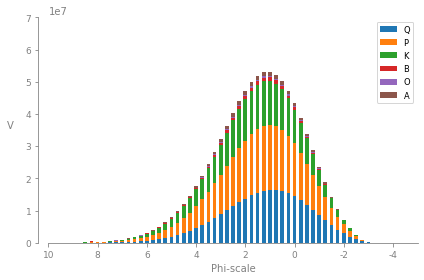

In [21]:
fig, ax = plt.subplots()

for d in range(0, 1500, 25):
    heights = np.sum(sedgen_CA_NS_mech.mcg[0, :, d:d+25] * sedgen_CA_NS_mech.volume_bins_medians_matrix[0, :, d:d+25], axis=1)
    for m in range(6):
        if d == 600:
            ax.bar(np.log2(sedgen_CA_NS_mech.size_bins[d]), height=heights[m], width=0.15, bottom=np.sum(heights[:m]), label=minerals[m], color=sns.color_palette()[m])
        else:
            ax.bar(np.log2(sedgen_CA_NS_mech.size_bins[d]), height=heights[m], width=0.15, bottom=np.sum(heights[:m]), color=sns.color_palette()[m])
            
            
# Set the color of the visible spines
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')

ax.set_xlim(-10, 5)
ax.set_ylim(0, 7e7)

ax.spines['bottom'].set_bounds(-10, 5)
ax.spines['left'].set_bounds(0, 7e7)

ax.spines['left'].set_position(('outward', 10))

# Set general tick parameters
ax.tick_params(axis='both',
               direction='out',
               colors='grey',
               labelsize=9)

ax.set_xlabel("Phi-scale", color='grey')
ax.set_ylabel("V", rotation=0, labelpad=15, color='grey')

ax.set_xticklabels(list(range(10, -6, -2)))

# Set facecolor of figure
plt.gcf().set_facecolor('white')

sns.despine()

plt.legend(fontsize='small')
plt.tight_layout()
# plt.savefig("_FIGURES/barplot_volume_mcg_mech_CA-NS.pdf")
plt.show();

C:\Users\u0108248\AppData\Local\Continuum\miniconda3\envs\sedgen\lib\site-packages\ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator


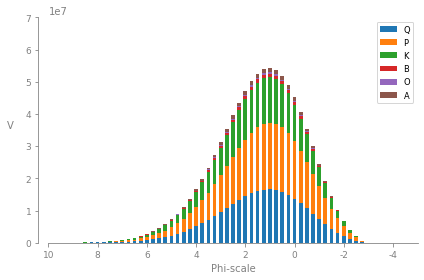

In [213]:
fig, ax = plt.subplots()

for d in range(0, 1500, 25):
    heights = np.sum(sedgen_CA_NS_mech.mcg[0, :, d:d+25] * sedgen_CA_NS_mech.volume_bins_medians_matrix[0, :, d:d+25], axis=1)
    for m in range(6):
        if d == 600:
            ax.bar(np.log2(sedgen_CA_NS_mech.size_bins[d]), height=heights[m], width=0.15, bottom=np.sum(heights[:m]), label=minerals[m], color=sns.color_palette()[m])
        else:
            ax.bar(np.log2(sedgen_CA_NS_mech.size_bins[d]), height=heights[m], width=0.15, bottom=np.sum(heights[:m]), color=sns.color_palette()[m])
            
            
# Set the color of the visible spines
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')

ax.set_xlim(-10, 5)
ax.set_ylim(0, 7e7)

ax.spines['bottom'].set_bounds(-10, 5)
ax.spines['left'].set_bounds(0, 7e7)

ax.spines['left'].set_position(('outward', 10))

# Set general tick parameters
ax.tick_params(axis='both',
               direction='out',
               colors='grey',
               labelsize=9)

ax.set_xlabel("Phi-scale", color='grey')
ax.set_ylabel("V", rotation=0, labelpad=15, color='grey')

ax.set_xticklabels(list(range(10, -6, -2)))

# Set facecolor of figure
plt.gcf().set_facecolor('white')

sns.despine()

plt.legend(fontsize='small')
plt.tight_layout()
plt.savefig("_FIGURES/barplot_volume_mcg_mech_CA-NS.pdf")
plt.show();

C:\Users\u0108248\AppData\Local\Continuum\miniconda3\envs\sedgen\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
C:\Users\u0108248\AppData\Local\Continuum\miniconda3\envs\sedgen\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
C:\Users\u0108248\AppData\Local\Continuum\miniconda3\envs\sedgen\lib\site-packages\ipykernel_launcher.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator


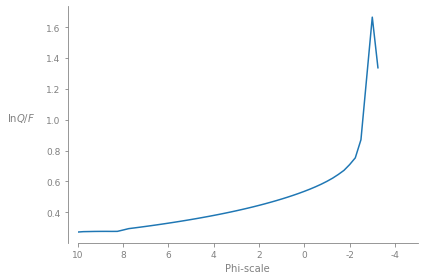

In [52]:
fig, ax = plt.subplots()

Q_values = np.zeros(1500//25)
P_values = np.zeros(1500//25)
K_values = np.zeros(1500//25)

for i, d in enumerate(range(0, 1500, 25)):
    Q_values[i] = np.sum(sedgen_CA_NS_mech.mcg[0, 0, d:d+25] * sedgen_CA_NS_mech.volume_bins_medians_matrix[0, 0, d:d+25])
    P_values[i] = np.sum(sedgen_CA_NS_mech.mcg[0, 1, d:d+25] * sedgen_CA_NS_mech.volume_bins_medians_matrix[0, 1, d:d+25])
    K_values[i] = np.sum(sedgen_CA_NS_mech.mcg[0, 2, d:d+25] * sedgen_CA_NS_mech.volume_bins_medians_matrix[0, 2, d:d+25])
    F_values = P_values + K_values

ax.plot(np.log2(sedgen_CA_NS_mech.size_bins[range(0, 1500, 25)]), Q_values/F_values)

# Set the color of the visible spines
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')

ax.set_xlim(-10, 5)
# ax.set_ylim(0, 7e7)

ax.spines['bottom'].set_bounds(-10, 5)
# ax.spines['left'].set_bounds(0, 7e7)

ax.spines['left'].set_position(('outward', 10))

# Set general tick parameters
ax.tick_params(axis='both',
               direction='out',
               colors='grey',
               labelsize=9)

ax.set_xlabel("Phi-scale", color='grey')
ax.set_ylabel(r"$\ln Q/F$", rotation=0, labelpad=25, color='grey')

ax.set_xticklabels(list(range(10, -6, -2)))

# Set facecolor of figure
plt.gcf().set_facecolor('white')

sns.despine()

# plt.legend(fontsize='small')
plt.tight_layout()
# plt.savefig("_FIGURES/barplot_volume_mcg_mech_CA-NS.pdf")
plt.show();

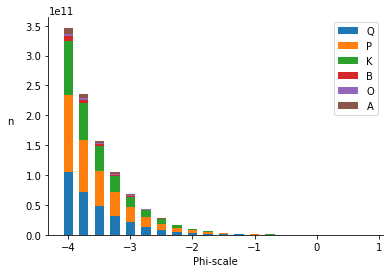

In [172]:
for d in range(600, 1100, 25):
    heights = np.sum(sedgen_CA_NS_mech.mcg[0, :, d:d+100], axis=1)
    for m in range(6):
        if d == 600:
            plt.bar(np.log2(sedgen_CA_NS_mech.size_bins[d]), height=heights[m], width=0.15, bottom=np.sum(heights[:m]), label=minerals[m], color=sns.color_palette()[m])
        else:
            plt.bar(np.log2(sedgen_CA_NS_mech.size_bins[d]), height=heights[m], width=0.15, bottom=np.sum(heights[:m]), color=sns.color_palette()[m])
plt.legend()
ax.set_xlabel([4, 3, 2, 1, 0, -1])
sns.despine()

plt.xlabel("Phi-scale")
plt.ylabel("n", rotation=0, labelpad=15)

plt.show();

## Chemical Weathering

In [22]:
%%time
sedgen_CA_NS_chem = \
    sedgen_CA_NS.weathering(
        operations=["chem_mcg", "chem_pcg"], 
        timesteps=100, inplace=False)

Wall time: 24.2 s


C:\Users\u0108248\AppData\Local\Continuum\miniconda3\envs\sedgen\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
C:\Users\u0108248\AppData\Local\Continuum\miniconda3\envs\sedgen\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
C:\Users\u0108248\AppData\Local\Continuum\miniconda3\envs\sedgen\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
C:\Users\u0108248\AppData\Local\Continuum\miniconda3\envs\sedgen\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
C:\Users\u0108248\AppData\Local\Continuum\miniconda3\envs\sedgen\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


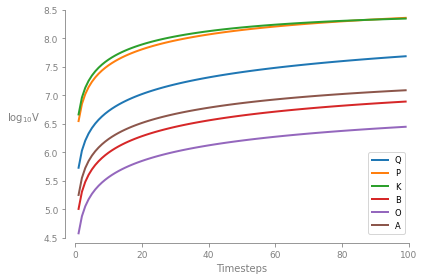

In [46]:
fig, ax = plt.subplots()

for i in range(6):
    ax.plot(np.log10(np.cumsum(sedgen_CA_NS_chem.pcg_chem_residue_additions[:, i])), label=sedgen_CA_NS.minerals[i], lw=2)
    
# Set the color of the visible spines
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')

ax.set_xlim(0, 100)
ax.set_ylim(4.5, 8.5)

ax.spines['bottom'].set_bounds(0, 100)
ax.spines['left'].set_bounds(4.5, 8.5)

ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 5))

# Set general tick parameters
ax.tick_params(axis='both',
               direction='out',
               colors='grey',
               labelsize=9)

ax.set_xlabel("Timesteps", color='grey')
ax.set_ylabel("$\log_{10}$V", rotation=0, labelpad=20, color='grey')

# ax.set_xticklabels(list(range(10, -6, -2)))

# Set facecolor of figure
plt.gcf().set_facecolor('white')

sns.despine()

plt.legend(fontsize='small')
plt.tight_layout()
plt.savefig("_FIGURES/lineplot_volume_residue_chem_CA-NS.pdf")
plt.show();

C:\Users\u0108248\AppData\Local\Continuum\miniconda3\envs\sedgen\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log2
  from ipykernel import kernelapp as app
C:\Users\u0108248\AppData\Local\Continuum\miniconda3\envs\sedgen\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log2
  del sys.path[0]
C:\Users\u0108248\AppData\Local\Continuum\miniconda3\envs\sedgen\lib\site-packages\ipykernel_launcher.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator


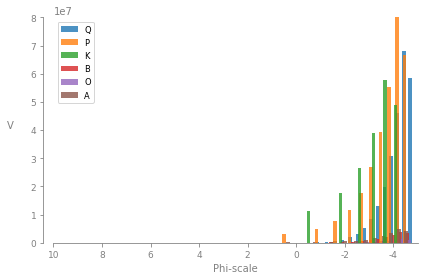

In [81]:
fig, ax = plt.subplots()

for d in range(0, 1500, 25):
    heights = np.zeros(6)
    for m in range(6):
        csd_filter = sedgen_CA_NS_chem.crystal_size_array_new[0][sedgen_CA_NS_chem.pcgs_new[0] == m]
        chem_state_filter = sedgen_CA_NS_chem.pcg_chem_weath_array_new[0][sedgen_CA_NS_chem.pcgs_new[0] == m]
        
        csd_filter_filtered = csd_filter[np.where((d <= csd_filter) & (csd_filter < d+25))]
        chem_state_filter_filtered = chem_state_filter[np.where((d <= csd_filter) & (csd_filter < d+25))]
        heights[m] = np.sum(sedgen_CA_NS_chem.volume_bins_medians_matrix[chem_state_filter_filtered, 0, csd_filter_filtered])
        if d == 600:
            ax.bar(np.log2(sedgen_CA_NS_chem.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
        else:
            ax.bar(np.log2(sedgen_CA_NS_chem.size_bins_matrix[99, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
            
# Set the color of the visible spines
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')

ax.set_xlim(-10, 5)
ax.set_ylim(0, 8e7)

ax.spines['bottom'].set_bounds(-10, 5)
ax.spines['left'].set_bounds(0, 8e7)

ax.spines['left'].set_position(('outward', 10))

# Set general tick parameters
ax.tick_params(axis='both',
               direction='out',
               colors='grey',
               labelsize=9)

ax.set_xlabel("Phi-scale", color='grey')
ax.set_ylabel("V", rotation=0, labelpad=20, color='grey')

ax.set_xticklabels(list(range(10, -6, -2)))

# Set facecolor of figure
plt.gcf().set_facecolor('white')

sns.despine()

plt.legend(fontsize='small')
plt.tight_layout()
plt.savefig("_FIGURES/barplot_volume_pcg_xx_chem_CA-NS.pdf")
plt.show();

C:\Users\u0108248\AppData\Local\Continuum\miniconda3\envs\sedgen\lib\site-packages\ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator


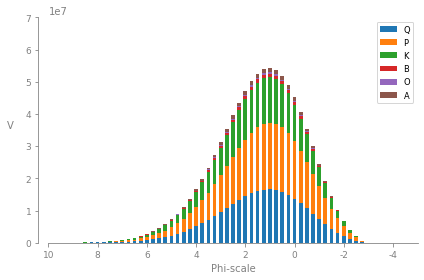

In [213]:
fig, ax = plt.subplots()

for d in range(0, 1500, 25):
    heights = np.sum(sedgen_CA_NS_mech.mcg[0, :, d:d+25] * sedgen_CA_NS_mech2.volume_bins_medians_matrix[0, :, d:d+25], axis=1)
    for m in range(6):
        if d == 600:
            ax.bar(np.log2(sedgen_CA_NS_mech.size_bins[d]), height=heights[m], width=0.15, bottom=np.sum(heights[:m]), label=minerals[m], color=sns.color_palette()[m])
        else:
            ax.bar(np.log2(sedgen_CA_NS_mech.size_bins[d]), height=heights[m], width=0.15, bottom=np.sum(heights[:m]), color=sns.color_palette()[m])
            
            
# Set the color of the visible spines
ax.spines['left'].setchem_state_filter_filterednes['bottom'].set_color('grey')

ax.set_xlim(-10, 5)
ax.set_ylim(0, 7e7)

ax.spines['bottom'].set_bounds(-10, 5)
ax.spines['left'].set_bounds(0, 7e7)

ax.spines['left'].set_position(('outward', 10))

# Set general tick parameters
ax.tick_params(axis='both',
               direction='out',
               colors='grey',
               labelsize=9)

ax.set_xlabel("Phi-scale", color='grey')
ax.set_ylabel("V", rotation=0, labelpad=15, color='grey')

ax.set_xticklabels(list(range(10, -6, -2)))

# Set facecolor of figure
plt.gcf().set_facecolor('white')

sns.despine()

plt.legend(fontsize='small')
plt.tight_layout()
plt.savefig("_FIGURES/barplot_volume_mcg_mech_CA-NS.pdf")
plt.show();

## Both weathering operations

In [82]:
%%time
sedgen_CA_NS_both = \
    sedgen_CA_NS.weathering(
    operations=["intra_cb", "inter_cb", 
                "chem_mcg", "chem_pcg"], 
    timesteps=100, inplace=False)

After 68 steps all pcgs have been broken down to mcg
Wall time: 1min 6s


In [177]:
%%time
sedgen_CA_NS_both2 = \
    sedgen_CA_NS.weathering(operations=["intra_cb", "inter_cb", "chem_mcg", "chem_pcg"], 
                            timesteps=30, inplace=False)

Wall time: 45.3 s


In [83]:
sedgen_CA_NS.interface_array
sedgen_CA_NS.crystal_size_array
sedgen_CA_NS.pcg_chem_weath_array_new[0]

array([1, 1, 3, ..., 0, 0, 5], dtype=uint8)

array([ 874,  998,  830, ..., 1463,  888,  753], dtype=uint16)

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [154]:
sedgen_CA_NS.residue.sum(axis=0)

array([16034572.23375518, 19412553.97561826, 13899259.64932888,
        1006130.58924192,   431895.49189993,  1249422.60409523])

In [99]:
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
        else:
            spine.set_color('none')  # don't draw spine

C:\Users\u0108248\AppData\Local\Continuum\miniconda3\envs\sedgen\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


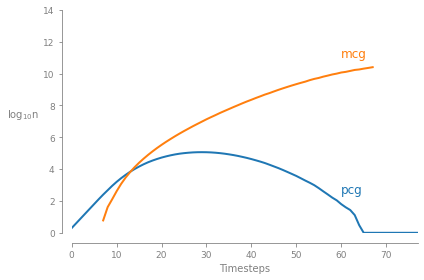

In [102]:
fig, ax = plt.subplots()

ax.plot(np.log10(sedgen_CA_NS_both.pcg_additions), label="pcg", lw=2)
ax.plot(np.log10(sedgen_CA_NS_both.mcg_additions), label="mcg", lw=2)

ax.text(60, 11, "mcg", color=sns.color_palette()[1], fontsize=12)
ax.text(60, 2.5, "pcg", color=sns.color_palette()[0], fontsize=12)

# Set the color of the visible spines
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')

ax.set_xlim(0, 77)
ax.set_ylim(0, 14)

ax.spines['bottom'].set_bounds(0, 77)
ax.spines['left'].set_bounds(0, 14)

adjust_spines(ax, ['left', 'bottom'])

# Set general tick parameters
ax.tick_params(axis='both',
               direction='out',
               colors='grey',
               labelsize=9)

ax.set_xlabel("Timesteps", color='grey')
ax.set_ylabel("$\log_{10}$n", rotation=0, labelpad=20, color='grey')

# Set facecolor of figure
plt.gcf().set_facecolor('white')

sns.despine()
# plt.legend()
plt.tight_layout()
plt.savefig("_FIGURES/lineplot_pcgmcg_evolution_both_CA-NS.pdf")
plt.show();

C:\Users\u0108248\AppData\Local\Continuum\miniconda3\envs\sedgen\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log2
  if __name__ == '__main__':
C:\Users\u0108248\AppData\Local\Continuum\miniconda3\envs\sedgen\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log2
  import sys
C:\Users\u0108248\AppData\Local\Continuum\miniconda3\envs\sedgen\lib\site-packages\ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator


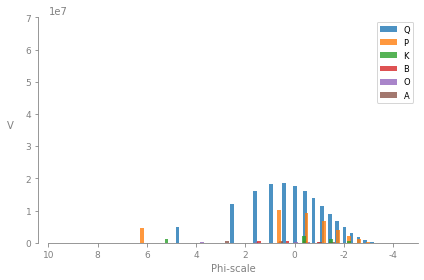

In [92]:
fig, ax = plt.subplots()

for d in range(0, 1500, 25):
    heights = np.sum(np.sum(sedgen_CA_NS_both.mcg[:, :, d:d+25] * sedgen_CA_NS_both.volume_bins_medians_matrix[:, :, d:d+25], axis=0), axis=1)
    for m in range(6):
        if d == 600:
            ax.bar(np.log2(sedgen_CA_NS_both.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, label=minerals[m], color=sns.color_palette()[m], alpha=0.8)
        else:
            ax.bar(np.log2(sedgen_CA_NS_both.size_bins_matrix[67, m, d]), height=heights[m], width=0.15, bottom=0, color=sns.color_palette()[m], alpha=0.8)
            
            
# Set the color of the visible spines
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')

ax.set_xlim(-10, 5)
ax.set_ylim(0, 7e7)

ax.spines['bottom'].set_bounds(-10, 5)
ax.spines['left'].set_bounds(0, 7e7)

ax.spines['left'].set_position(('outward', 10))

# Set general tick parameters
ax.tick_params(axis='both',
               direction='out',
               colors='grey',
               labelsize=9)

ax.set_xlabel("Phi-scale", color='grey')
ax.set_ylabel("V", rotation=0, labelpad=15, color='grey')

ax.set_xticklabels(list(range(10, -6, -2)))

# Set facecolor of figure
plt.gcf().set_facecolor('white')

sns.despine()

plt.legend(fontsize='small')
plt.tight_layout()
plt.savefig("_FIGURES/barplot_volume_mcg_both_CA-NS.pdf")
plt.show();